In [208]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np

In [209]:
target  = pd.read_pickle('files/Target.pkl')
desired = pd.read_pickle('files/Desired.pkl')
display(target.head())
display(desired.head())

,ax,ay,az,wx,wy,wz,time
0,-0.337944,-0.343994,7.239196,3.731570,-0.062499,1.539075,0.00
1,-0.256701,-0.289915,6.724431,3.475130,-0.080483,1.431842,0.00
2,-0.105883,-0.200782,6.241739,3.244595,-0.124124,1.333691,0.02
3,0.125146,-0.072412,5.787254,3.037949,-0.192071,1.243422,0.04
4,0.434959,0.091973,5.353423,2.852055,-0.274701,1.159130,0.04


,pitch,roll,yaw,wx,wy,wz,ax,ay,az,time
790,26.60,-49.98,307.93,722.0,-2628.0,-106.0,221.0,174.0,265.0,0.00
791,27.80,-55.47,306.93,716.0,-2374.0,-239.0,301.0,160.0,237.0,0.00
792,28.77,-60.41,305.73,704.0,-2019.0,-36.0,299.0,224.0,184.0,0.02
793,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04
794,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04


# ANÁLISE

In [210]:
key  = 'ax'
time = target.time.values
yTarget  = np.array(target[key])
yDesired = np.array(desired[key])

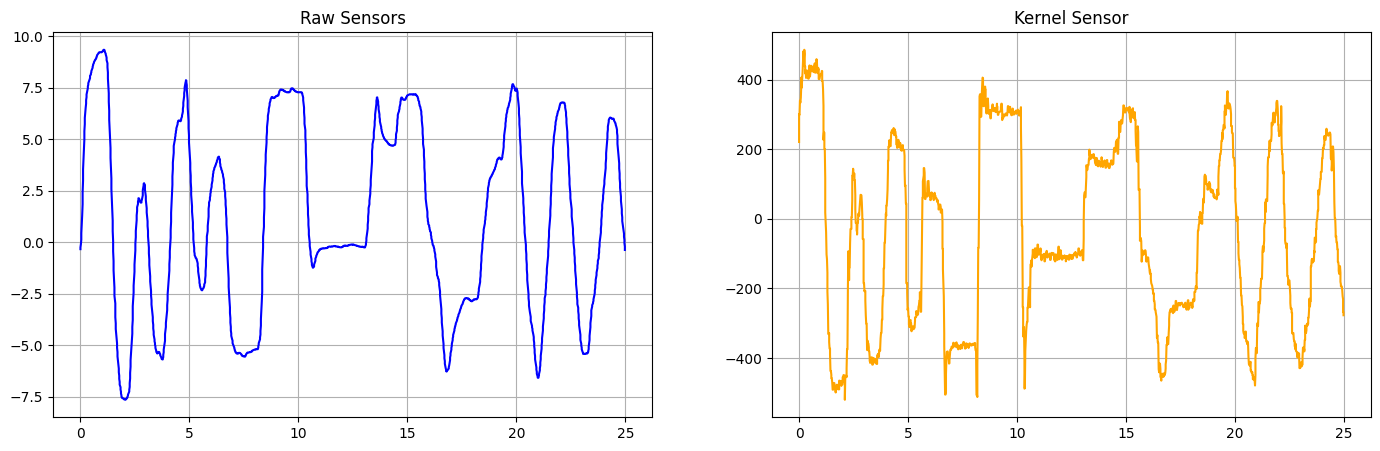

In [211]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(time, yTarget, color='blue')
plt.title('Raw Sensors')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, yDesired, color='orange')
plt.title('Kernel Sensor')
plt.grid()

- Comparação normalizada com erro relacionado à distancia entre os pontos

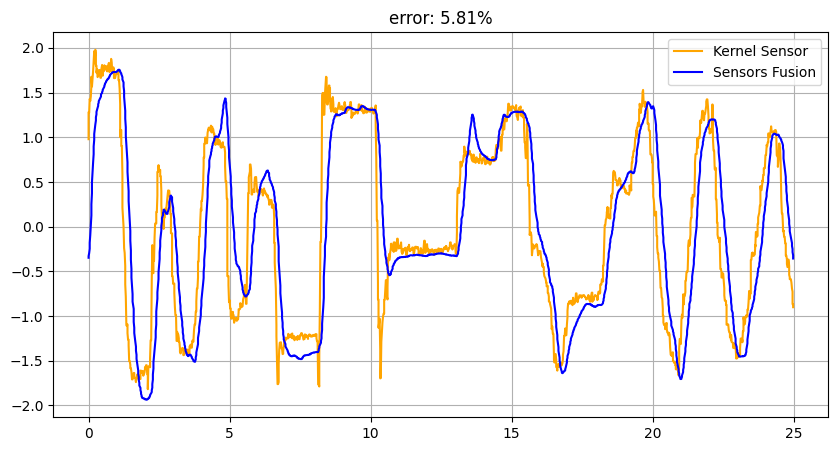

In [212]:
def normalize(data):
    return np.array(data - np.mean(data))/np.std(data)

def compare(data1, data2):
    data1 = normalize(data1)
    data2 = normalize(data2)
    score = wasserstein_distance(data1, data2)
    return data1, data2, score


d, t, score = compare(yDesired, yTarget)
plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# TENTANDO CALCULAR PITCH, ROLL E YAW

In [213]:
import math

class Quaternion:
    def __init__(self, w=1.0, x=0.0, y=0.0, z=0.0):
        self.w = float(w)
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)

    def __mul__(self, other):
        if not isinstance(other, Quaternion):
            return Quaternion(self.w*other, self.x*other, self.y*other, self.z*other)
        
        w = self.w * other.w - self.x * other.x - self.y * other.y - self.z * other.z
        x = self.w * other.x + self.x * other.w + self.y * other.z - self.z * other.y
        y = self.w * other.y - self.x * other.z + self.y * other.w + self.z * other.x
        z = self.w * other.z + self.x * other.y - self.y * other.x + self.z * other.w
        return Quaternion(w, x, y, z)

    def __add__(self, other):
        return Quaternion(self.w + other.w, self.x + other.x, self.y + other.y, self.z + other.z)

    def conj(self):
        return Quaternion(self.w, -self.x, -self.y, -self.z)

    def norm(self):
        return math.sqrt(self.w**2 + self.x**2 + self.y**2 + self.z**2)

    def normalize(self):
        n = self.norm()

        if n != 0:
            self.w /= n
            self.x /= n
            self.y /= n
            self.z /= n

    __rmul__ = __mul__


class Orientation:
    DEG2RAD = 1 # math.pi / 180.0

    def __init__(self, dt=0.02, beta=0.1):
        self.q     = Quaternion()
        self.beta  = beta
        self.dt    = dt
        self.pitch = self.roll = self.yaw = 0.0

    def update(self, gx, gy, gz, ax, ay, az):
        gx *= self.DEG2RAD
        gy *= self.DEG2RAD
        gz *= self.DEG2RAD

        q1,q2,q3,q4 = self.q.w, self.q.x, self.q.y, self.q.z
        norm = math.sqrt(ax*ax + ay*ay + az*az)
        dt   = self.dt
        
        if norm == 0:
            return
        
        ax, ay, az = ax/norm, ay/norm, az/norm
        _2q1, _2q2, _2q3, _2q4 = 2*q1, 2*q2, 2*q3, 2*q4
        _4q1, _4q2, _4q3       = 4*q1, 4*q2, 4*q3
        _8q2, _8q3             = 8*q2, 8*q3
        q1q1,q2q2,q3q3,q4q4    = q1*q1,q2*q2,q3*q3,q4*q4

        s1 = _4q1*q3q3 + _2q3*ax + _4q1*q2q2 - _2q2*ay
        s2 = _4q2*q4q4 - _2q4*ax + 4*q1q1*q2 - _2q1*ay - _4q2 + _8q2*(q2q2+q3q3) + _4q2*az
        s3 = 4*q1q1*q3 + _2q1*ax + _4q3*q4q4 - _2q4*ay - _4q3 + _8q3*(q2q2+q3q3) + _4q3*az
        s4 = 4*q2q2*q4 - _2q2*ax + 4*q3q3*q4 - _2q3*ay
        norm_s = math.sqrt(s1*s1 + s2*s2 + s3*s3 + s4*s4)
        
        if norm_s == 0:
            return
        
        s1, s2, s3, s4 = s1/norm_s, s2/norm_s, s3/norm_s, s4/norm_s
        qDot1 = 0.5*(-q2*gx - q3*gy - q4*gz) - self.beta*s1
        qDot2 = 0.5*( q1*gx + q3*gz - q4*gy) - self.beta*s2
        qDot3 = 0.5*( q1*gy - q2*gz + q4*gx) - self.beta*s3
        qDot4 = 0.5*( q1*gz + q2*gy - q3*gx) - self.beta*s4
        
        q1 += qDot1*dt
        q2 += qDot2*dt
        q3 += qDot3*dt
        q4 += qDot4*dt
        
        self.q = Quaternion(q1, q2, q3, q4)
        self.q.normalize()
        self.toEuler()

    def toEuler(self):
        q = self.q
        sinr_cosp = 2*(q.w*q.x + q.y*q.z)
        cosr_cosp = 1 - 2*(q.x*q.x + q.y*q.y)
        self.roll = math.atan2(sinr_cosp, cosr_cosp)

        sinp = 2*(q.w*q.y - q.z*q.x)
        self.pitch = math.copysign(math.pi/2, sinp) if abs(sinp) >= 1 else math.asin(sinp)

        siny_cosp = 2*(q.w*q.z + q.x*q.y)
        cosy_cosp = 1 - 2*(q.y*q.y + q.z*q.z)
        self.yaw = math.atan2(siny_cosp, cosy_cosp)


orientation = Orientation(dt=0.02, beta=0.80)
eulerData   = []

for i in range(len(target.ax)):
    ax, ay, az = target.ax.values[i], target.ay.values[i], target.az.values[i]
    wx, wy, wz = target.wx.values[i], target.wy.values[i], target.wz.values[i]

    orientation.update(wx, wy, wz, ax, ay, az)
    eulerData.append([orientation.pitch, orientation.roll, orientation.yaw])

target['pitch'] = [pitch for (pitch, roll, yaw) in eulerData]
target['roll']  = [roll  for (pitch, roll, yaw) in eulerData]
target['yaw']   = [yaw   for (pitch, roll, yaw) in eulerData]

# COMPARANDO PITCH, ROLL, YAW

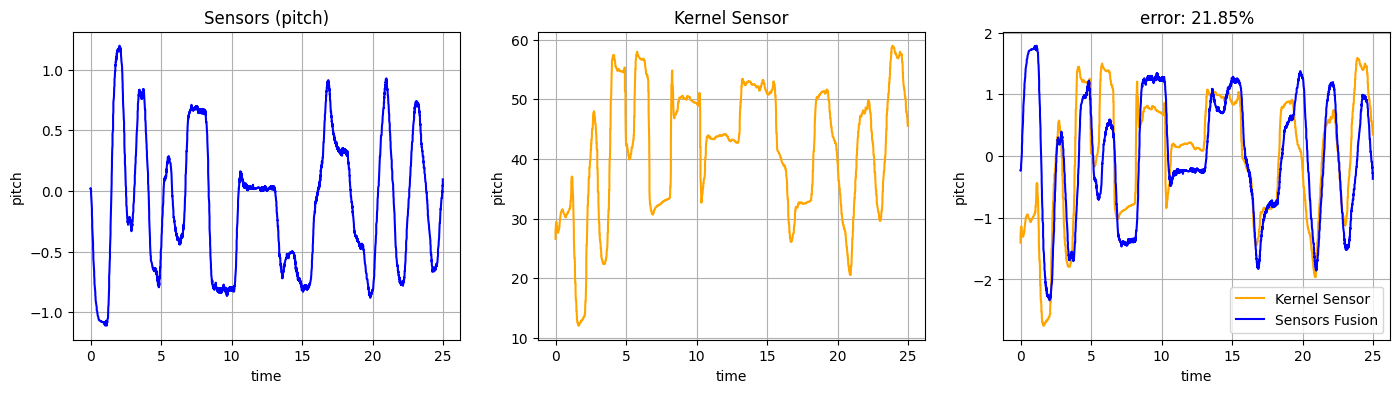

In [214]:
k, s, score = compare(desired.pitch, target.pitch)

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(target.time, target.pitch, color='blue')
plt.title('Sensors (pitch)'), plt.xlabel('time'), plt.ylabel('pitch')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(desired.time, desired.pitch, color='orange')
plt.title('Kernel Sensor'), plt.xlabel('time'), plt.ylabel('pitch')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(desired.time, k, color='orange', label='Kernel Sensor')
plt.plot(target.time, -s, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%'), plt.xlabel('time'), plt.ylabel('pitch')
plt.legend(), plt.grid()
plt.show()

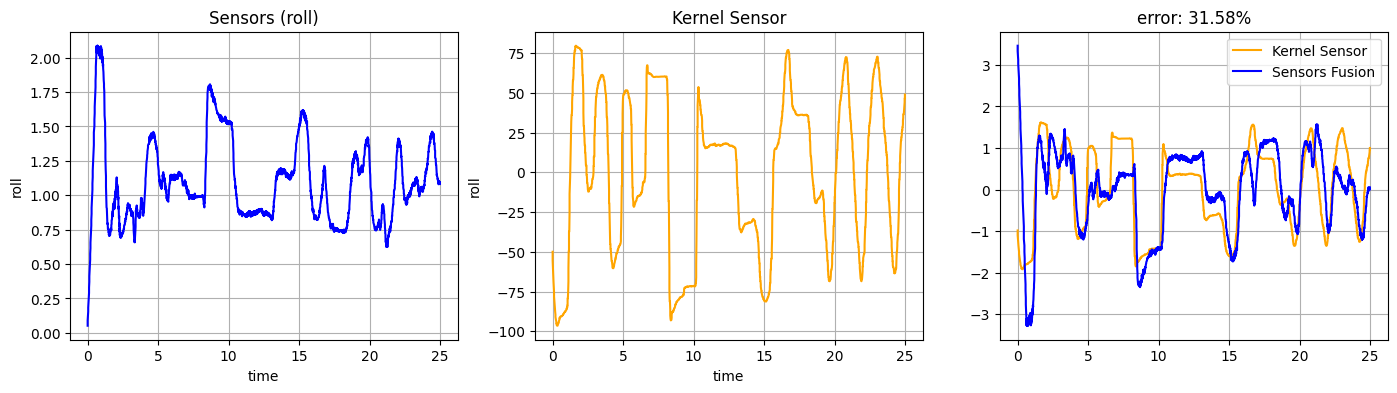

In [215]:
k, s, score = compare(desired.roll, target.roll)

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(target.time, target.roll, color='blue')
plt.title('Sensors (roll)'), plt.xlabel('time'), plt.ylabel('roll')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(desired.time, desired.roll, color='orange')
plt.title('Kernel Sensor'), plt.xlabel('time'), plt.ylabel('roll')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(desired.time, k, color='orange', label='Kernel Sensor')
plt.plot(target.time, -s, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

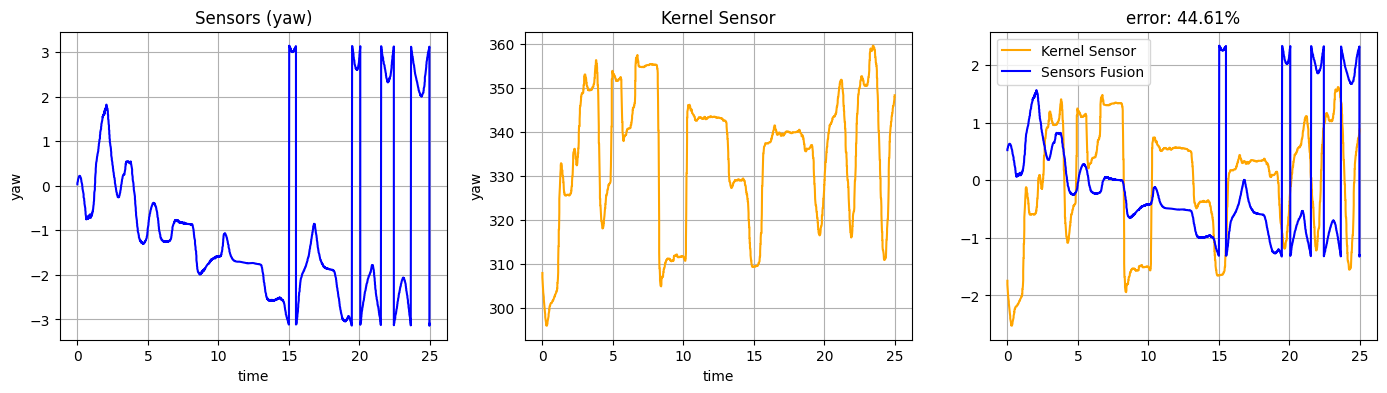

In [216]:
k, s, score = compare(desired.yaw, target.yaw)

plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(target.time, target.yaw, color='blue')
plt.title('Sensors (yaw)'), plt.xlabel('time'), plt.ylabel('yaw')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(desired.time, desired.yaw, color='orange')
plt.title('Kernel Sensor'), plt.xlabel('time'), plt.ylabel('yaw')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(desired.time, k, color='orange', label='Kernel Sensor')
plt.plot(target.time, s, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()